In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_artificial_dataset():
    np.random.seed(42)

    # Parâmetros para a Classe 1
    mean1 = [1, 1]
    cov1 = [[0.1, 0], [0, 0.1]]
    class1 = np.random.multivariate_normal(mean1, cov1, 10)

    # Parâmetros para a Classe 0
    mean2 = [0, 0]
    cov2 = [[0.1, 0], [0, 0.1]]
    class0_1 = np.random.multivariate_normal(mean2, cov2, 10)

    mean3 = [0, 1]
    cov3 = [[0.1, 0], [0, 0.1]]
    class0_2 = np.random.multivariate_normal(mean3, cov3, 10)

    mean4 = [1, 0]
    cov4 = [[0.1, 0], [0, 0.1]]
    class0_3 = np.random.multivariate_normal(mean4, cov4, 10)

    class0 = np.vstack((class0_1, class0_2, class0_3))

    # Combinar as classes
    X_artificial = np.vstack((class1, class0))
    y_artificial = np.array([1]*10 + [0]*30)

    return X_artificial, y_artificial

In [3]:
X, y = generate_artificial_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
def compute_likelihood(X, mean, std):
    likelihood = np.prod(norm.pdf(X, mean, std))
    return likelihood

In [6]:
class NaiveBayesClassifier:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_probs = {}
        self.mean = {}
        self.std = {}

        for c in self.classes:
            X_c = X[y == c]
            self.class_probs[c] = len(X_c) / len(X)
            self.mean[c] = np.mean(X_c, axis=0)
            self.std[c] = np.std(X_c, axis=0)

    def predict(self, X):
        predictions = []
        posteriors = []

        for x in X:
            posteriors_per_instance = []

            for c in self.classes:
                likelihood = compute_likelihood(x, self.mean[c], self.std[c])
                posterior = self.class_probs[c] * likelihood
                posteriors_per_instance.append(posterior)

            predicted_class = self.classes[np.argmax(posteriors_per_instance)]
            predictions.append(predicted_class)
            posteriors.append(posteriors_per_instance)

        class_posteriors = {c: [] for c in self.classes}
        
        for posterior in posteriors:
            for i, p in enumerate(posterior):
                class_posteriors[self.classes[i]].append(p)

        mean_class_posteriors = {c: np.mean(class_posteriors[c], axis=0) for c in self.classes}
        return predictions, mean_class_posteriors

In [7]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [8]:
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    num_classes = len(classes)
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(num_classes):
        for j in range(num_classes):
            matrix[i, j] = np.sum((y_true == classes[i]) & (y_pred == classes[j]))
    return matrix

In [9]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    test_samples = int(len(X) * test_size)
    X_train = X[indices[:-test_samples]]
    X_test = X[indices[-test_samples:]]
    y_train = y[indices[:-test_samples]]
    y_test = y[indices[-test_samples:]]
    return X_train, X_test, y_train, y_test

In [10]:
def plot_confusion_matrix(confusion_matrix, title=""):
 
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Matriz de Confusão')
  plt.show()

In [11]:
def plot_accuracy_std(accuracy, title=""):

  plt.figure(figsize=(8, 6))
  std_accuracy = np.std(accuracy)
  plt.hist(accuracy, bins=10, edgecolor='black', alpha=0.7)
  plt.axvline(std_accuracy, color='red', linestyle='dashed', linewidth=2, label=f'Desvio Padrão: {std_accuracy:.2f}')
  plt.xlabel("Acurácia")
  plt.ylabel("Frequência")
  plt.title(title)
  plt.legend()
  plt.show()

In [12]:
def perform_realizations(classifier, X, y):
    accuracies = []
    class_posteriors_all = []

    for _ in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=_)
        classifier.fit(X_train, y_train)
        y_pred, class_posteriors = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        class_posteriors_all.append(class_posteriors)

    accuracies = np.array(accuracies)
    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)
    best_realization_idx = np.argmin(np.abs(accuracies - mean_accuracy))

    best_class_posteriors = class_posteriors_all[best_realization_idx]
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print("Dataset: Iris")
    print(f"Melhor acurácia: {mean_accuracy}")
    plot_accuracy_std(accuracies, title="Distribuição e Desvio Padrão")
    print(f"Melhor realização (índice): {best_realization_idx}")
    plot_confusion_matrix(conf_matrix)

    return mean_accuracy, std_dev_accuracy, best_realization_idx, best_class_posteriors

In [13]:
def plot_decision_surface(clf, X_train, y_train, title):
   
    X_train = X_train[:, :2]
    
    clf.fit(X_train, y_train)

    h = .02  
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])[0] 

    Z = np.array(Z)
    
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

In [14]:
def plot_gaussian_over_data(X_train, y_train, X_test, y_test, title):
    plt.figure(figsize=(12, 8))

    for i, class_name in enumerate(np.unique(y_train)):
        X_class_train = X_train[y_train == class_name]
        X_class_test = X_test[y_test == class_name]

        mean = np.mean(X_class_train, axis=0)
        std = np.std(X_class_train, axis=0)
        plt.scatter(X_class_train[:, 0], X_class_train[:, 1], label=f'Train Class {class_name}')
        plt.scatter(mean[0], mean[1], marker='x', color='black', label=f'Mean Train Class {class_name}')

        plt.scatter(X_class_test[:, 0], X_class_test[:, 1], label=f'Test Class {class_name}')
        plt.scatter(mean[0], mean[1], marker='o', color='red', label=f'Mean Test Class {class_name}')

    plt.title(title)
    plt.legend()
    plt.show()

In [15]:
def plot_data(X, y, title=""):
 
  plt.figure(figsize=(8, 6))

  colors = {label: plt.cm.get_cmap('tab10')(i) for i, label in enumerate(np.unique(y))}

  for i, point in enumerate(X):
    plt.scatter(point[0], point[1], color=colors[y[i]], label=y[i])

  plt.xlabel("Sepal lenth(cm)")
  plt.ylabel("Sepal width(cm)")
  plt.title(title)
 

  plt.show()

In [16]:
nb_classifier = NaiveBayesClassifier()

C:\Users\gleilsonpedro\AppData\Local\Temp\ipykernel_21128\3349150294.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = {label: plt.cm.get_cmap('tab10')(i) for i, label in enumerate(np.unique(y))}


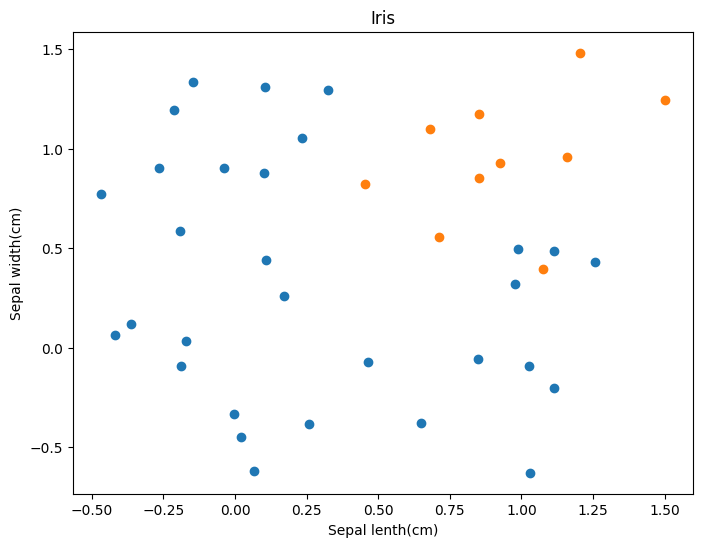

In [17]:
plot_data(X, y, title="Iris")

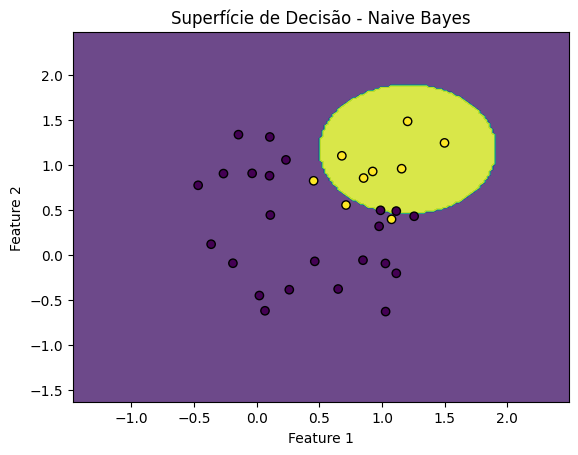

Dataset: Iris
Melhor acurácia: 0.86875


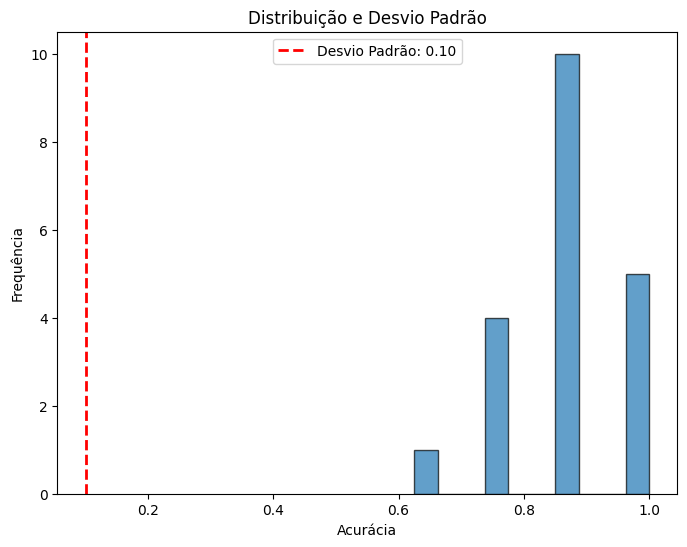

Melhor realização (índice): 0


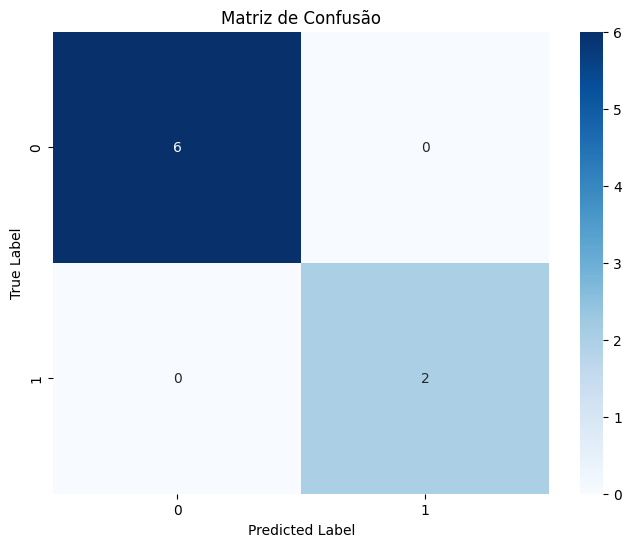

In [18]:
plot_decision_surface(nb_classifier, X_train, y_train, "Superfície de Decisão - Naive Bayes")
mean_acc, std_dev_acc, best_realization_idx, best_class_posteriors = perform_realizations(nb_classifier, X, y)

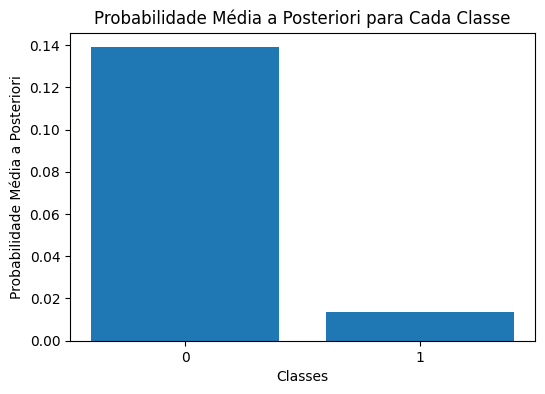

In [19]:
plt.figure(figsize=(6, 4))
plt.bar(range(len(best_class_posteriors)), best_class_posteriors.values())
plt.xlabel('Classes')
plt.ylabel('Probabilidade Média a Posteriori')
plt.title('Probabilidade Média a Posteriori para Cada Classe')
plt.xticks(range(len(best_class_posteriors)))
plt.show()

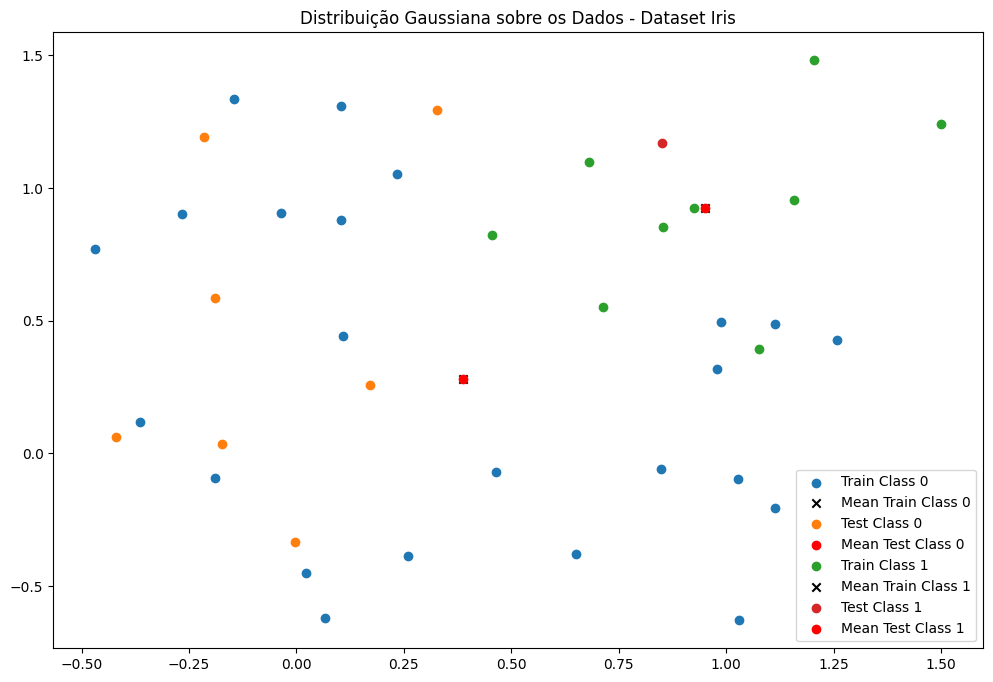

In [20]:
plot_gaussian_over_data(X_train, y_train, X_test, y_test, "Distribuição Gaussiana sobre os Dados - Dataset Iris")